## Install required packages

In [1]:
# !pip install pandas numpy scikit-learn rich

import pandas as pd
import ast
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix, hstack, diags
from collections import Counter
from rich.console import Console
from rich.table import Table
from rich import box
import matplotlib.pyplot as plt
import seaborn as sns

### Initialize console for rich output

In [2]:
console = Console()
console.print("[bold green]Starting the recommender system setup with TF-ICF...[/bold green]")

Starting the recommender system setup with TF-ICF...

## Step 0: Load the dataset and do pre processing

In [3]:
df = pd.read_csv('arXiv_scientific dataset.csv')
# Drop rows with missing summaries
df = df.dropna(subset=['summary']).reset_index(drop=True)

# Clean title and summary (remove extra whitespace)
for col in ['title', 'summary']:
    df[col] = df[col].str.replace('\n', ' ').str.replace('\r', ' ').str.replace('\t', ' ')
    df[col] = df[col].str.replace('  ', ' ').str.strip()

# Parse authors column (assumes authors are stored as strings that can be evaluated as lists)
df['authors'] = df['authors'].apply(ast.literal_eval)

# Combine title and summary into a single text column
df['text'] = df['title'] + ' ' + df['summary']

## Step 1: Compute TF-ICF Matrix

In [4]:
# Get unique categories and total number (N)
unique_categories = df['category'].unique()
N = len(unique_categories)
console.print(f"[bold cyan]Total number of unique categories: {N}[/bold cyan]")

# Map categories to indices for easy access
category_to_index = {cat: idx for idx, cat in enumerate(unique_categories)}

# Collect unique terms per category
category_terms = [set() for _ in range(N)]
for idx, row in df.iterrows():
    category_idx = category_to_index[row['category']]
    terms = set(row['text'].split())  # Split text into words
    category_terms[category_idx].update(terms)

# Compute Term Frequency (TF) using CountVectorizer
count_vectorizer = CountVectorizer(max_features=15000, min_df=5, max_df=0.85)
tf_matrix = count_vectorizer.fit_transform(df['text'])
feature_names = count_vectorizer.get_feature_names_out()
console.print(f"[bold cyan]TF matrix shape: {tf_matrix.shape}[/bold cyan]")

# Calculate Inverse Category Frequency (ICF) for each term
term_icf = {}
for term in feature_names:
    cf = sum(1 for cat_set in category_terms if term in cat_set)  # Number of categories with the term
    term_icf[term] = np.log(N / cf) if cf > 0 else 0  # ICF formula: log(N / cf)

# Create ICF vector aligned with feature names
icf_vector = np.array([term_icf.get(term, 0) for term in feature_names])

# Compute TF-ICF matrix by weighting TF with ICF
tf_icf_matrix = tf_matrix.multiply(icf_vector)

# Normalize the TF-ICF matrix (each row sums to 1)
row_sums = tf_icf_matrix.sum(axis=1)  # Returns a (n_rows, 1) matrix
row_sums = np.asarray(row_sums).ravel()  # Convert to 1D array
row_sums[row_sums == 0] = 1  # Avoid division by zero
inv_row_sums = 1 / row_sums
normalizer = diags(inv_row_sums, 0)
tf_icf_matrix = normalizer.dot(tf_icf_matrix)
console.print(f"[bold cyan]TF-ICF matrix shape: {tf_icf_matrix.shape}[/bold cyan]")


Total number of unique categories: 138

TF matrix shape: (136238, 15000)

TF-ICF matrix shape: (136238, 15000)

## Step 2: Add Category Features

In [5]:
category_dummies = pd.get_dummies(df['category'], prefix='category')
category_sparse = csr_matrix(category_dummies.values)
console.print(f"[bold cyan]Category matrix shape: {category_sparse.shape}[/bold cyan]")

Category matrix shape: (136238, 138)

## Step 3: Add Author Features

In [6]:
# Select top 2000 most frequent authors
author_counter = Counter()
for authors_list in df['authors']:
    author_counter.update(authors_list)
top_authors = [author for author, _ in author_counter.most_common(2000)]
console.print(f"[bold cyan]Number of unique authors: {len(author_counter)}, using top {len(top_authors)}[/bold cyan]")

# Create author presence matrix
author_matrix = np.zeros((len(df), len(top_authors)), dtype=int)
for i, authors_list in enumerate(df['authors']):
    for author in authors_list:
        if author in top_authors:
            author_matrix[i, top_authors.index(author)] = 1
author_sparse = csr_matrix(author_matrix)
console.print(f"[bold cyan]Author matrix shape: {author_sparse.shape}[/bold cyan]")

Number of unique authors: 197018, using top 2000

Author matrix shape: (136238, 2000)

## Step 4: Combine All Features

In [7]:
feature_matrix = hstack([tf_icf_matrix, category_sparse, author_sparse])
feature_matrix = feature_matrix.tocsr()  # Ensure CSR format
console.print(f"[bold cyan]Combined feature matrix shape: {feature_matrix.shape}[/bold cyan]")

# Define column indices for each feature part
n_tf_icf = tf_icf_matrix.shape[1]
n_category = category_sparse.shape[1]
n_author = author_sparse.shape[1]
tf_icf_indices = list(range(0, n_tf_icf))
category_indices = list(range(n_tf_icf, n_tf_icf + n_category))
author_indices = list(range(n_tf_icf + n_category, n_tf_icf + n_category + n_author))

Combined feature matrix shape: (136238, 17138)

## Recommendation Functions

In [8]:
def recommend_similar_papers(paper_index, feature_matrix, df, top_n=5):
    """
    Recommend papers similar to the paper at paper_index.
    
    Args:
        paper_index (int): Index of the paper to find similarities for.
        feature_matrix (sparse matrix): Combined feature matrix.
        df (DataFrame): Dataset with paper details.
        top_n (int): Number of recommendations to return.
    
    Returns:
        DataFrame: Top similar papers with similarity scores.
    """
    similarities = cosine_similarity(feature_matrix[paper_index], feature_matrix).flatten()
    similar_indices = similarities.argsort()[-(top_n + 1):-1][::-1]  # Exclude self, get top N
    similar_papers = df.iloc[similar_indices].copy()
    similar_papers['similarity'] = similarities[similar_indices]
    return similar_papers

def recommend_papers_for_query(query, vectorizer, feature_matrix, df, top_n=5, category=None, authors=None):
    """
    Recommend papers based on a text query, with optional category and authors.
    
    Args:
        query (str): Text query to match papers against.
        vectorizer (CountVectorizer): Fitted CountVectorizer for text transformation.
        feature_matrix (sparse matrix): Combined feature matrix.
        df (DataFrame): Dataset with paper details.
        top_n (int): Number of recommendations to return.
        category (str, optional): Category to filter by (if provided).
        authors (list, optional): List of authors to filter by (if provided).
    
    Returns:
        DataFrame: Top matching papers with similarity scores.
    """
    # Transform query to TF vector and apply ICF
    query_tf = vectorizer.transform([query])
    query_tf_icf = query_tf.multiply(icf_vector)
    # Normalize query vector (sum to 1)
    query_sum = query_tf_icf.sum(axis=1)
    query_sum = np.asarray(query_sum).ravel()
    query_sum[query_sum == 0] = 1  # Avoid division by zero
    query_tf_icf = query_tf_icf.multiply(1 / query_sum)

    # Prepare category vector
    if category and category in df['category'].unique():
        category_vector = np.zeros(len(category_dummies.columns))
        category_vector[category_dummies.columns.get_loc(f'category_{category}')] = 1
        category_vector = csr_matrix(category_vector.reshape(1, -1))
    else:
        category_vector = csr_matrix((1, category_sparse.shape[1]))

    # Prepare author vector
    if authors:
        author_vector = np.zeros((1, len(top_authors)))
        for author in authors:
            if author in top_authors:
                author_vector[0, top_authors.index(author)] = 1
        author_vector = csr_matrix(author_vector)
    else:
        author_vector = csr_matrix((1, author_sparse.shape[1]))

    # Determine which features to use based on inputs
    active_indices = tf_icf_indices.copy()  # Always include TF-ICF features
    query_parts = [query_tf_icf]  # Start with TF-ICF part of the query

    if category is not None:
        active_indices += category_indices  # Include category features
        query_parts.append(category_vector)
    if authors is not None:
        active_indices += author_indices  # Include author features
        query_parts.append(author_vector)

    # Construct the query feature vector with only the relevant parts
    query_feature_active = hstack(query_parts)

    # Select the corresponding columns from the feature matrix
    feature_matrix_active = feature_matrix[:, active_indices]

    # Compute similarities using only the selected features
    similarities = cosine_similarity(query_feature_active, feature_matrix_active).flatten()
    similar_indices = similarities.argsort()[-top_n:][::-1]
    similar_papers = df.iloc[similar_indices].copy()
    similar_papers['similarity'] = similarities[similar_indices]
    return similar_papers

def display_suggestions(suggestions: pd.DataFrame):
    """
    Display recommended papers in a rich table format.
    
    Args:
        suggestions (DataFrame): DataFrame with recommended papers and similarity scores.
    """
    table = Table(
        title="[bold bright_blue]Recommended Articles[/bold bright_blue]",
        title_style="bold underline",
        box=box.DOUBLE_EDGE,
        border_style="bright_green",
        show_lines=True,
        padding=(0, 1)
    )
    table.add_column("Title", style="bold cyan", overflow="fold")
    table.add_column("Category", style="green", overflow="fold", justify="left")
    table.add_column("Published Date", style="magenta")
    table.add_column("Authors", style="yellow", overflow="fold")
    table.add_column("Summary", style="orchid", overflow="fold")
    table.add_column("Similarity", style="bright_red")
    
    for _, row in suggestions.iterrows():
        table.add_row(
            f"[bold]{row.get('title', 'N/A')}[/bold]",
            row.get('category', 'N/A'),
            str(row.get('published_date', 'N/A')),
            ", ".join(row.get('authors', [])),
            row.get('summary', 'N/A'),
            f"{row.get('similarity', 0):.4f}"
        )
    console.print(table)

### Example 1: Recommend papers similar to the first paper

In [9]:
console.print("\n[bold magenta]Example 1: Recommendations for paper at index 0:[/bold magenta]")
suggestions = recommend_similar_papers(10511, feature_matrix, df, top_n=5)
display_suggestions(suggestions)

Example 1: Recommendations for paper at index 0:

                                               Recommended Articles                                                
╔════════════════════╤════════════════════╤════════════════╤════════════════════╤════════════════════╤════════════╗
║ Title              │ Category           │ Published Date │ Authors            │ Summary            │ Similarity ║
╟────────────────────┼────────────────────┼────────────────┼────────────────────┼────────────────────┼────────────╢
║ Formal Model of    │ Artificial         │ 3/20/13        │ Arthur Ramer       │ Given a universe   │ 0.9889     ║
║ Uncertainty for    │ Intelligence       │                │                    │ of discourse X-a   │            ║
║ Possibilistic      │                    │                │                    │ domain of possible │            ║
║ Rules              │                    │                │                    │ outcomes-an        │            ║
║                    │                    │                │                    │ experiment may     │            ║
║                    │                    │                │                    │ consist of         │            ║
║                    │                    │                │                    │ selecting one of   │            ║
║                    │                    │                │                    │ its elements,      │            ║
║                    │                    │                │                    │ subject to the     │            ║
║                    │                    │                │                    │ operation of       │            ║
║                    │                    │                │                    │ chance, or of      │            ║
║                    │                    │                │                    │ observing the      │            ║
║                    │                    │                │                    │ elements, subject  │            ║
║                    │                    │                │                    │ to imprecision. A  │            ║
║                    │                    │                │                    │ priori uncertainty │            ║
║                    │                    │                │                    │ about the actual   │            ║
║                    │                    │                │                    │ result of the      │            ║
║                    │                    │                │                    │ experiment may be  │            ║
║                    │                    │                │                    │ quantified,        │            ║
║                    │                    │                │                    │ representing       │            ║
║                    │                    │                │                    │ either the         │            ║
║                    │                    │                │                    │ likelihood of the  │            ║
║                    │                    │                │                    │ choice of :r_X or  │            ║
║                    │                    │                │                    │ the degree to      │            ║
║                    │                    │                │                    │ which any such X   │            ║
║                    │                    │                │                    │ would be suitable  │            ║
║                    │                    │                │                    │ as a description   │            ║
║                    │                    │                │                    │ of the outcome.    │            ║
║                    │                    │                │                    │ The former case    │            ║
║                    │                    │                │                    │ corresponds to a   │            ║
║                    │                    │             

### Example 2: Recommend papers based on a text query only

In [10]:
query = "We propose an improved dependency-directed backtracking method that reduces search progress loss"
console.print(f"\n[bold magenta]Example 2: Recommendations for query: '{query}'[/bold magenta]")
suggestions = recommend_papers_for_query(query, count_vectorizer, feature_matrix, df, top_n=5)
display_suggestions(suggestions)

Example 2: Recommendations for query: 'We propose an improved dependency-directed backtracking method that reduces 
search progress loss'

                                               Recommended Articles                                                
╔════════════════════╤════════════════════╤════════════════╤════════════════════╤════════════════════╤════════════╗
║ Title              │ Category           │ Published Date │ Authors            │ Summary            │ Similarity ║
╟────────────────────┼────────────────────┼────────────────┼────────────────────┼────────────────────┼────────────╢
║ Dynamic            │ Artificial         │ 8/1/93         │ M. L. Ginsberg     │ Because of their   │ 0.6455     ║
║ Backtracking       │ Intelligence       │                │                    │ occasional need to │            ║
║                    │                    │                │                    │ return to shallow  │            ║
║                    │                    │                │                    │ points in a search │            ║
║                    │                    │                │                    │ tree, existing     │            ║
║                    │                    │                │                    │ backtracking       │            ║
║                    │                    │                │                    │ methods can        │            ║
║                    │                    │                │                    │ sometimes erase    │            ║
║                    │                    │                │                    │ meaningful         │            ║
║                    │                    │                │                    │ progress toward    │            ║
║                    │                    │                │                    │ solving a search   │            ║
║                    │                    │                │                    │ problem. In this   │            ║
║                    │                    │                │                    │ paper, we present  │            ║
║                    │                    │                │                    │ a method by which  │            ║
║                    │                    │                │                    │ backtrack points   │            ║
║                    │                    │                │                    │ can be moved       │            ║
║                    │                    │                │                    │ deeper in the      │            ║
║                    │                    │                │                    │ search space,      │            ║
║                    │                    │                │                    │ thereby avoiding   │            ║
║                    │                    │                │                    │ this difficulty.   │            ║
║                    │                    │                │                    │ The technique      │            ║
║                    │                    │                │                    │ developed is a     │            ║
║                    │                    │                │                    │ variant of         │            ║
║                    │                    │                │                    │ dependency-directe │            ║
║                    │                    │                │                    │ d backtracking     │            ║
║                    │                    │                │                    │ that uses only     │            ║
║                    │                    │                │                    │ polynomial space   │            ║
║                    │                    │                │                    │ while still        │            ║
║                    │                    │                │                    │ providing useful   │            ║
║                    │                    │                │                    │ control            │            ║
║                    │                    │             

# Trend Analysis

In [11]:
# Load the dataset
df = pd.read_csv('arXiv_scientific dataset.csv')

# Preprocess data
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')
df = df.dropna(subset=['published_date'])  # Drop rows with missing dates
df['year'] = df['published_date'].dt.year

# Parse 'authors' column if it's a string representation of a list
if isinstance(df['authors'].iloc[0], str):
    df['authors'] = df['authors'].apply(ast.literal_eval)

# Explode 'authors' for author-based analysis
df_exploded = df.explode('authors')

C:\Users\himas\AppData\Local\Temp\ipykernel_22196\1832287200.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')


### Trend Analysis Section

Starting Trend Analysis

Plotting total papers published per year

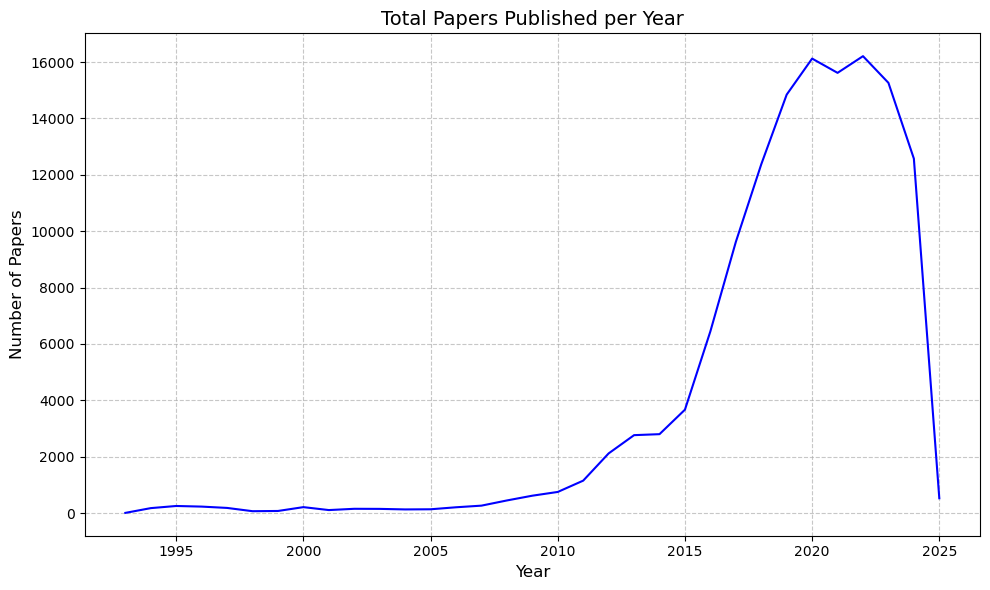

Plotting publication counts of top 5 categories over time

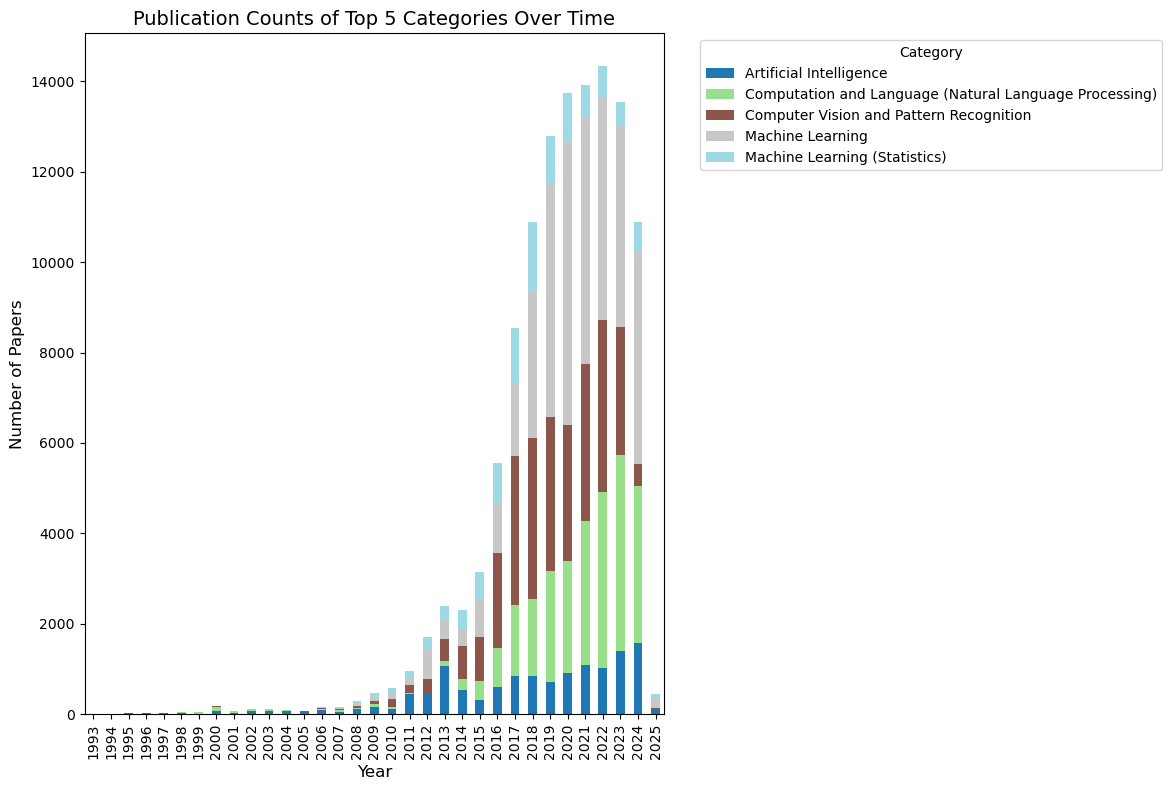

Plotting publication trends for top 5 most prolific authors

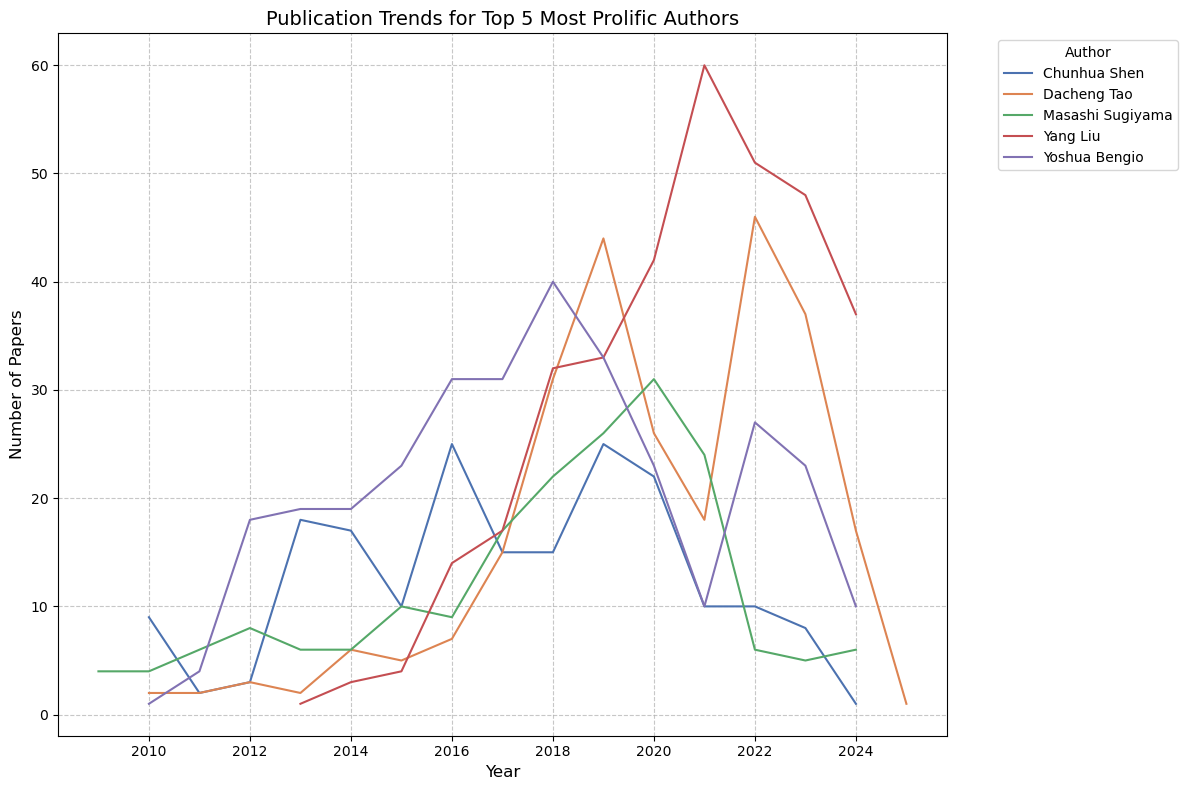

Plotting category publication frequency by year (heatmap)

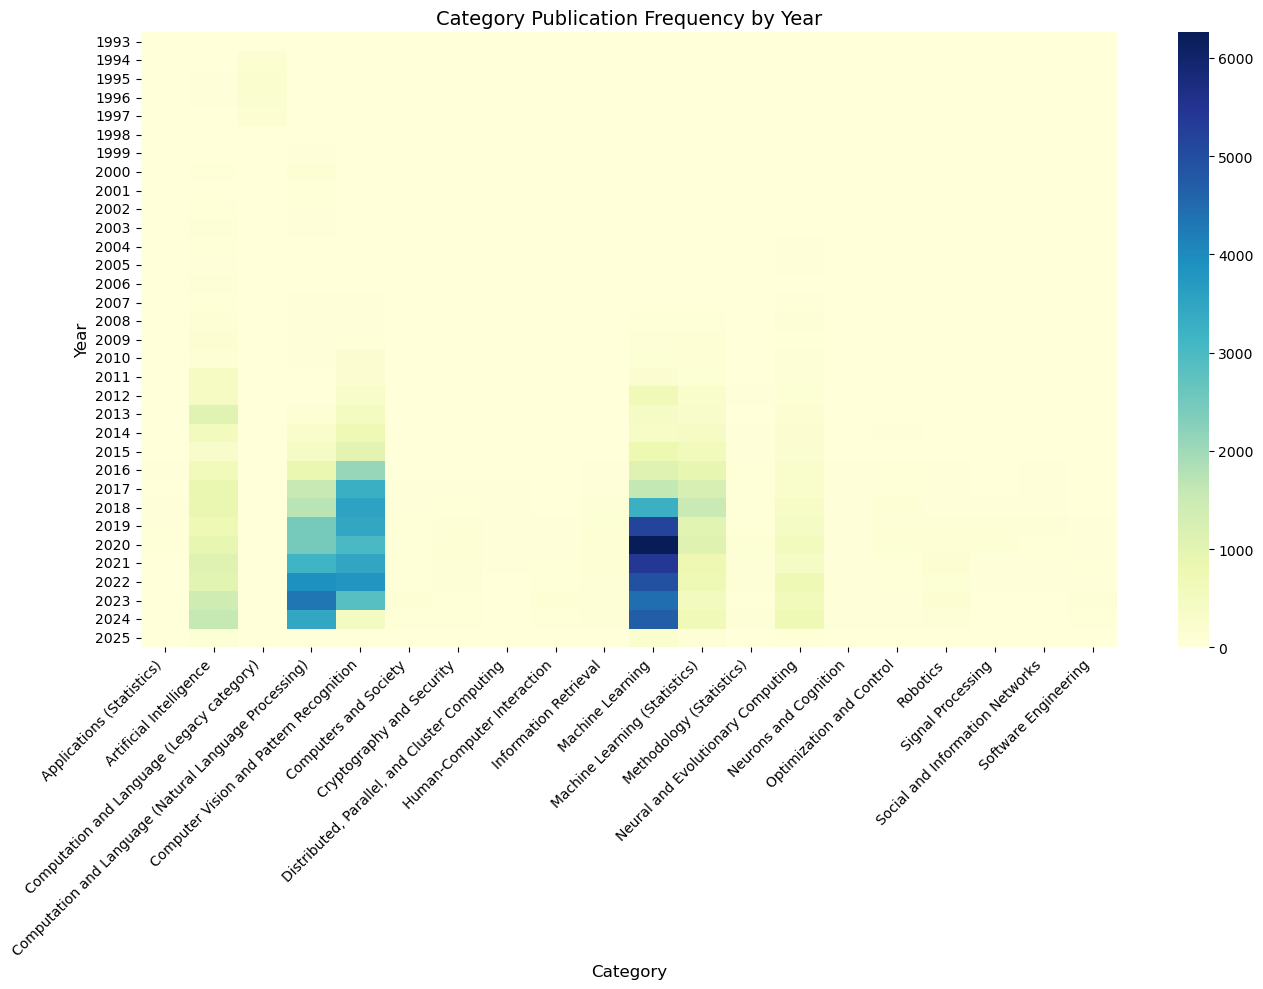

Plotting top 10 authors by total paper count

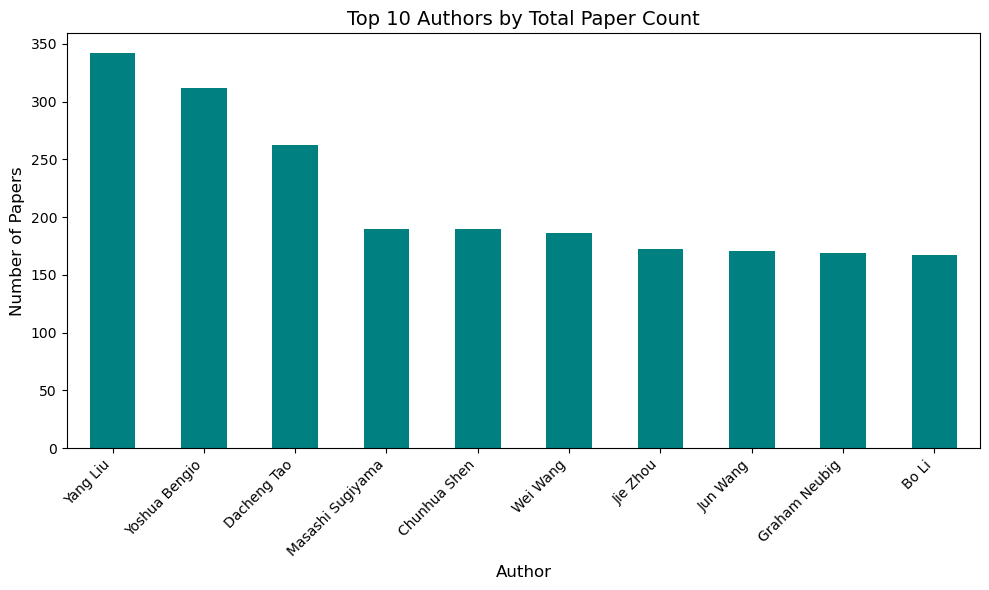

Plotting average number of authors per paper over time

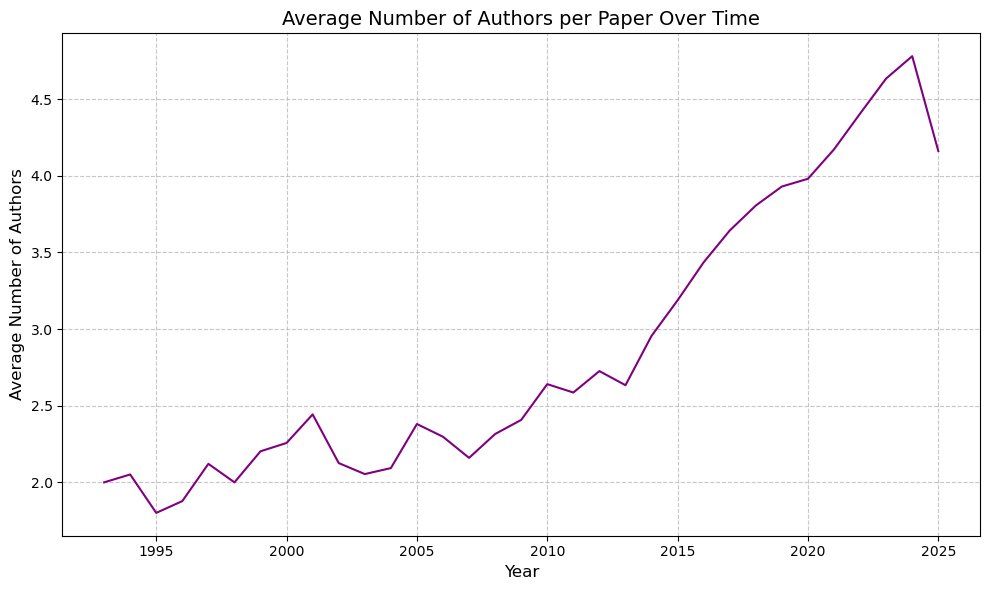

Plotting top 10 categories by total paper count

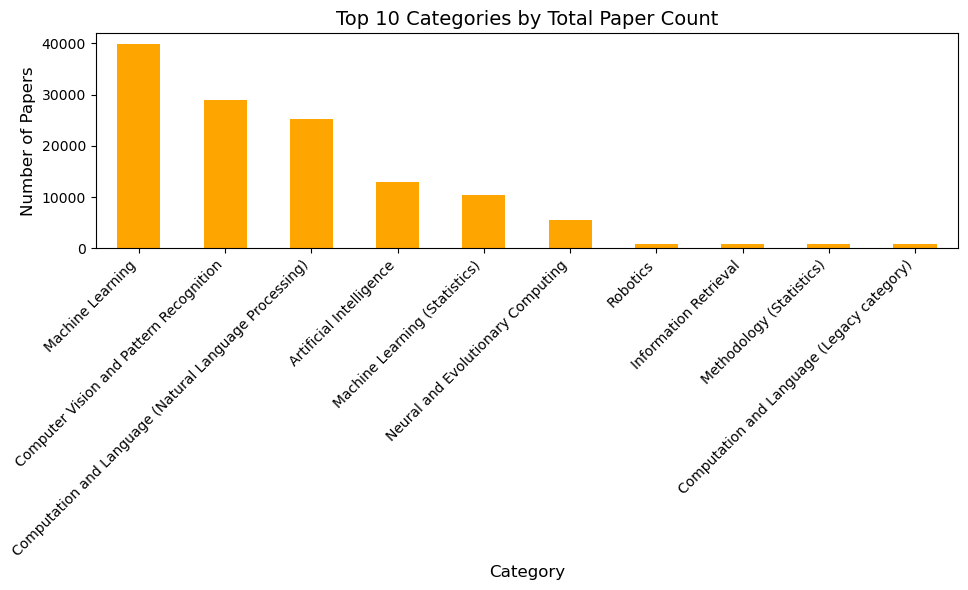

Trend Analysis Completed

Starting Additional Trend Analysis

Plotting monthly publication counts

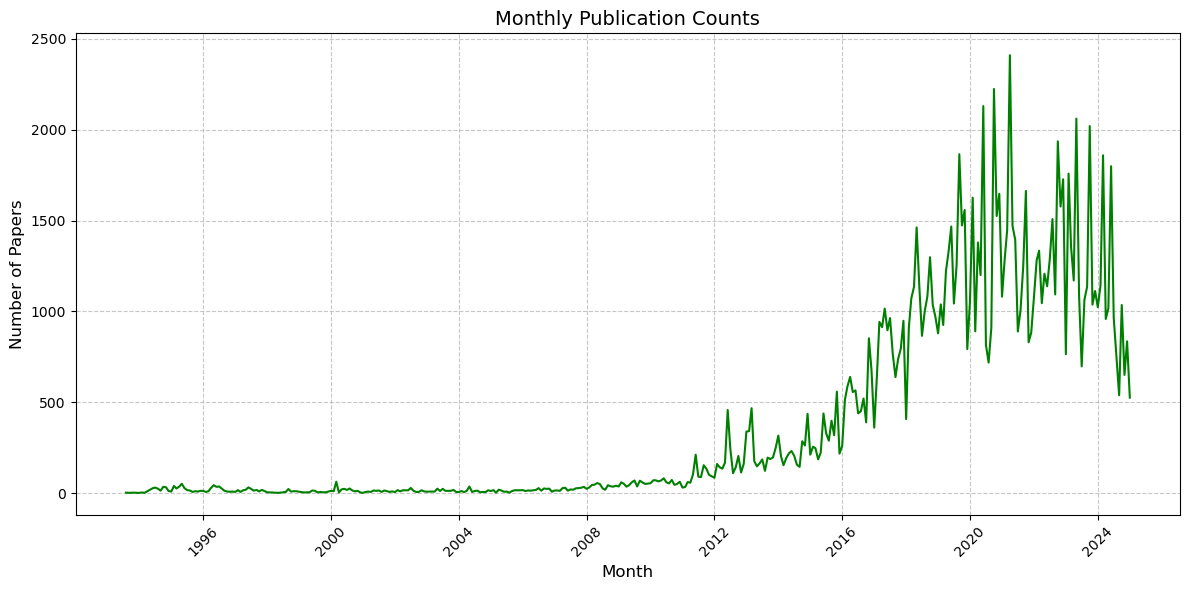

Plotting cumulative papers for top 5 categories

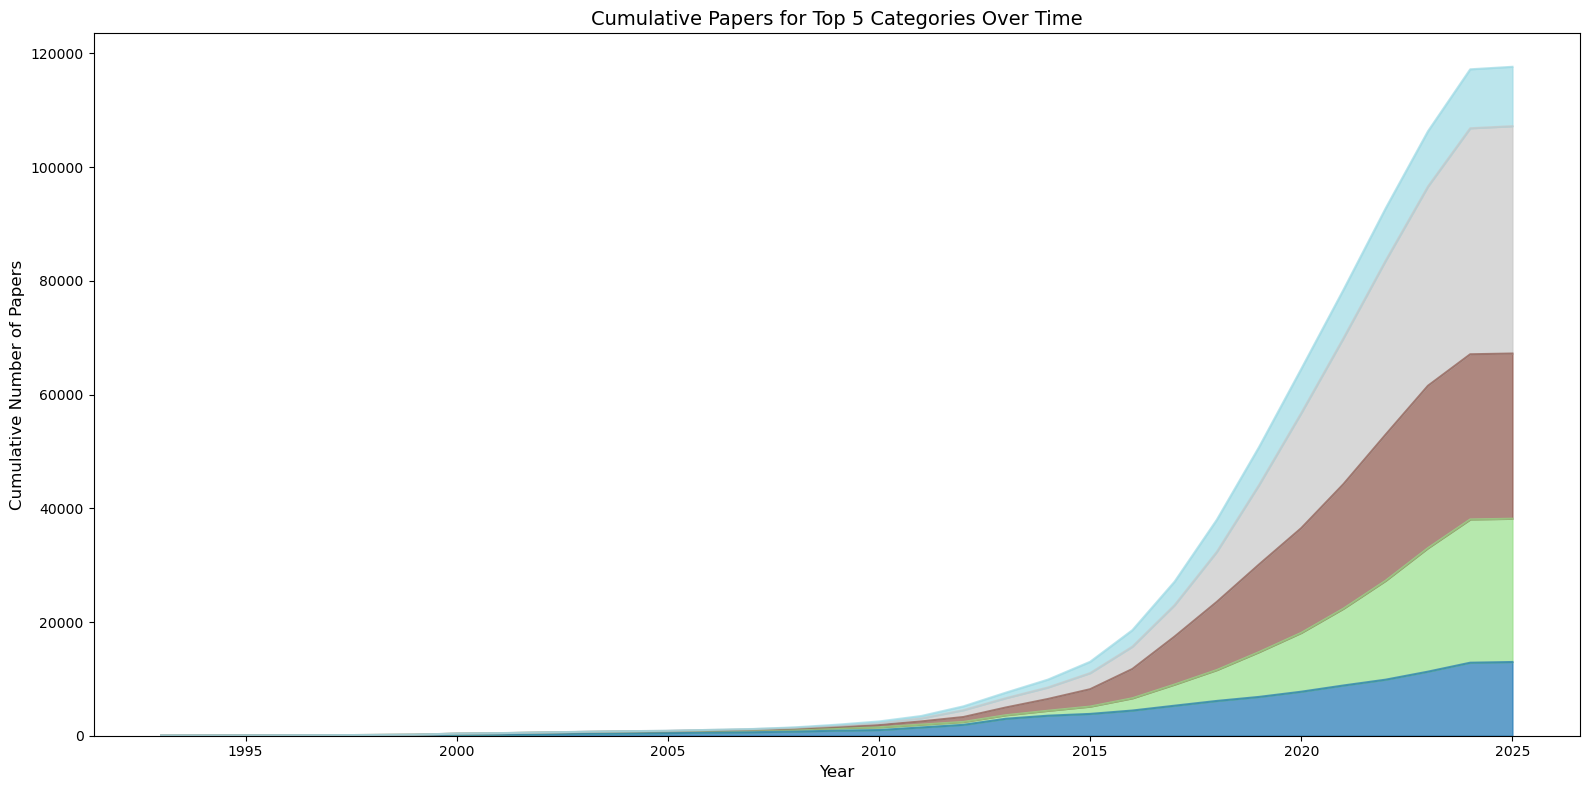

Plotting year-over-year percentage change for top 3 growing categories

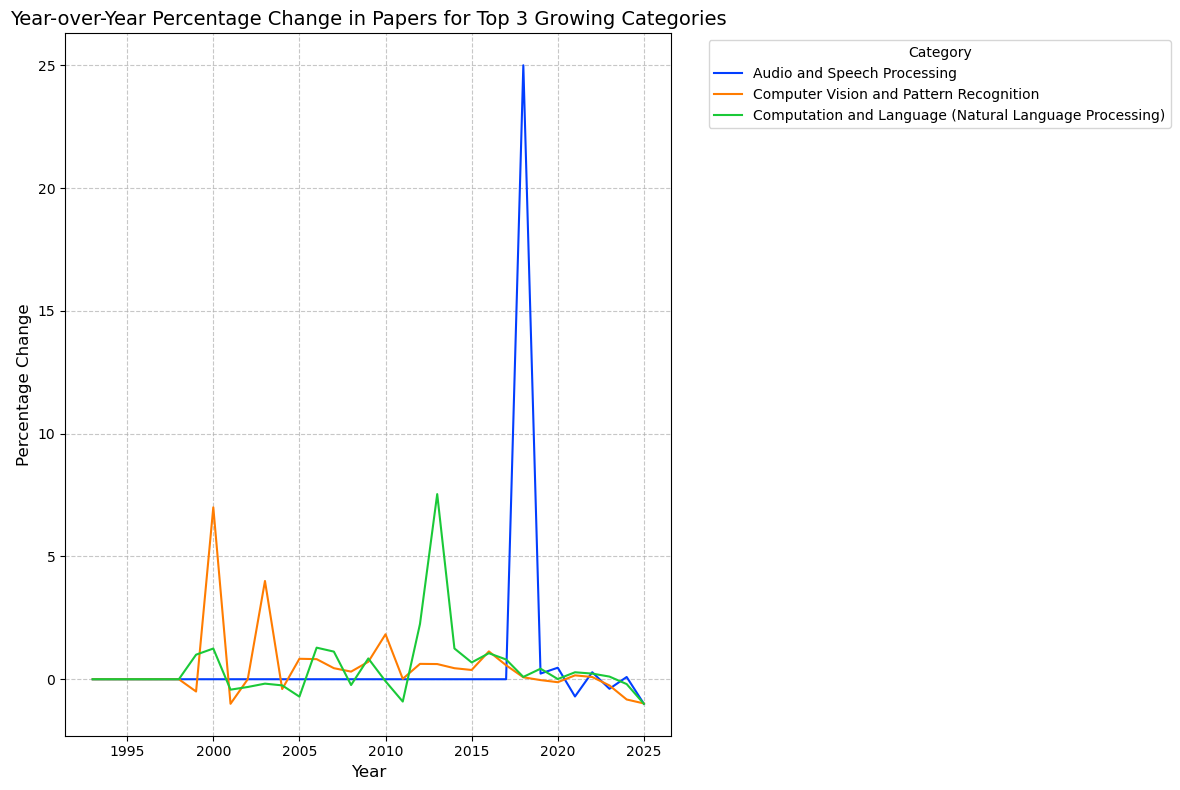

Plotting average publication lag for top 10 authors over years

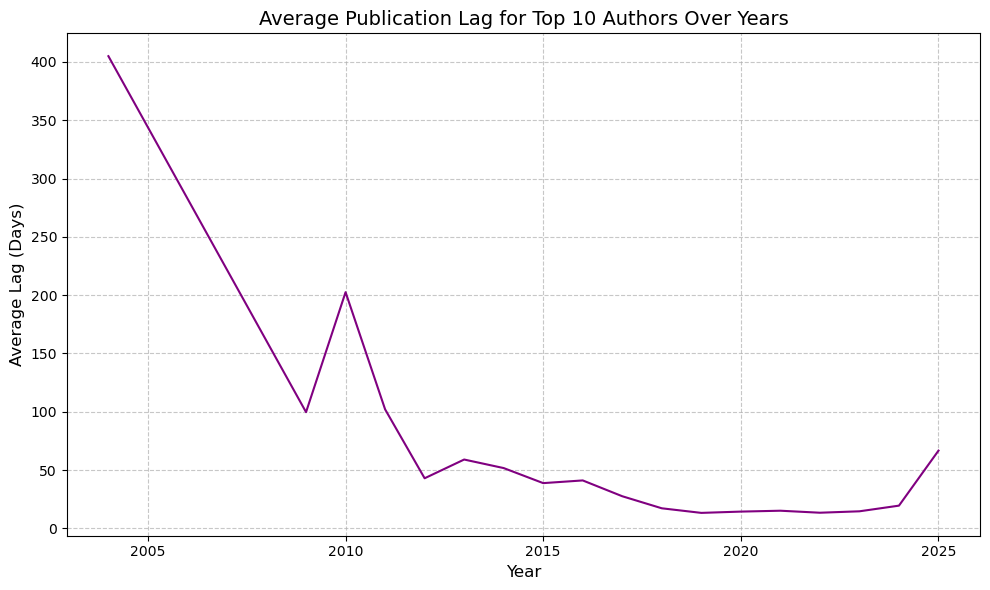

In [12]:
console.print("[bold green]Starting Trend Analysis[/bold green]")

# 1. Line Plot: Total Papers Published per Year
console.print("[bold blue]Plotting total papers published per year[/bold blue]")
papers_per_year = df.groupby('year').size()
plt.figure(figsize=(10, 6))
sns.lineplot(x=papers_per_year.index, y=papers_per_year.values, color='blue')
plt.title('Total Papers Published per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/total_papers_per_year.png', dpi=300)
plt.show(); plt.show(); plt.close()

# 2. Stacked Bar Plot: Top 5 Categories’ Publication Counts Over Time
console.print("[bold blue]Plotting publication counts of top 5 categories over time[/bold blue]")
top_categories = df['category'].value_counts().head(5).index
df_top_cat = df[df['category'].isin(top_categories)]
cat_per_year = df_top_cat.groupby(['year', 'category']).size().unstack(fill_value=0)
cat_per_year.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')
plt.title('Publication Counts of Top 5 Categories Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('plots/top_categories_over_time.png', dpi=300)
plt.show(); plt.close()

# 3. Multi-Line Plot: Publication Trends for Top 5 Most Prolific Authors
console.print("[bold blue]Plotting publication trends for top 5 most prolific authors[/bold blue]")
top_authors = df_exploded['authors'].value_counts().head(5).index
df_top_authors = df_exploded[df_exploded['authors'].isin(top_authors)]
author_per_year = df_top_authors.groupby(['authors', 'year']).size().reset_index(name='count')
plt.figure(figsize=(12, 8))
sns.lineplot(data=author_per_year, x='year', y='count', hue='authors', palette='deep')
plt.title('Publication Trends for Top 5 Most Prolific Authors', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)
plt.legend(title='Author', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/top_authors_publication_trends.png', dpi=300)
plt.show(); plt.close()

# 4. Heatmap: Category Publication Frequency by Year (Top 20 Categories)
console.print("[bold blue]Plotting category publication frequency by year (heatmap)[/bold blue]")
top_categories_heatmap = df['category'].value_counts().head(20).index
cat_year_matrix = df[df['category'].isin(top_categories_heatmap)].groupby(['year', 'category']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 10))
sns.heatmap(cat_year_matrix, cmap='YlGnBu', annot=False, fmt='d')
plt.title('Category Publication Frequency by Year', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plots/category_heatmap.png', dpi=300)
plt.show(); plt.close()

# 5. Bar Plot: Top 10 Authors by Total Paper Count
console.print("[bold blue]Plotting top 10 authors by total paper count[/bold blue]")
top_10_authors = df_exploded['authors'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_10_authors.plot(kind='bar', color='teal')
plt.title('Top 10 Authors by Total Paper Count', fontsize=14)
plt.xlabel('Author', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plots/top_10_authors.png', dpi=300)
plt.show(); plt.close()

# 6. Line Plot: Average Number of Authors per Paper Over Time
console.print("[bold blue]Plotting average number of authors per paper over time[/bold blue]")
df['num_authors'] = df['authors'].apply(len)
avg_authors_per_year = df.groupby('year')['num_authors'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_authors_per_year.index, y=avg_authors_per_year.values, color='purple')
plt.title('Average Number of Authors per Paper Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Number of Authors', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/avg_authors_per_year.png', dpi=300)
plt.show(); plt.close()

# 7. Bar Plot: Top 10 Categories by Total Paper Count
console.print("[bold blue]Plotting top 10 categories by total paper count[/bold blue]")
top_10_categories = df['category'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_10_categories.plot(kind='bar', color='orange')
plt.title('Top 10 Categories by Total Paper Count', fontsize=14)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('plots/top_10_categories.png', dpi=300)
plt.show(); plt.close()

console.print("[bold green]Trend Analysis Completed[/bold green]")

# Additional Trend Analysis Section with New Plots
console.print("[bold green]Starting Additional Trend Analysis[/bold green]")

# 1. Line Plot: Monthly Publication Counts to Show Seasonal Patterns
console.print("[bold blue]Plotting monthly publication counts[/bold blue]")
df['month'] = df['published_date'].dt.to_period('M').dt.to_timestamp()
monthly_counts = df.groupby('month').size()
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_counts.index, y=monthly_counts.values, color='green')
plt.title('Monthly Publication Counts', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/monthly_publication_counts.png', dpi=300)
plt.show(); plt.close()

# 2. Area Plot: Cumulative Papers for Top 5 Categories Over Time
console.print("[bold blue]Plotting cumulative papers for top 5 categories[/bold blue]")

top_categories = df['category'].value_counts().head(5).index
df_top_cat = df[df['category'].isin(top_categories)]
cat_year_counts = df_top_cat.groupby(['year', 'category']).size().unstack(fill_value=0)
cumulative_counts = cat_year_counts.cumsum()

# Create figure and axis for main plot
fig, ax = plt.subplots(figsize=(16, 8))  # Full-width plot
cumulative_counts.plot(kind='area', stacked=True, colormap='tab20', alpha=0.7, ax=ax)

ax.set_title('Cumulative Papers for Top 5 Categories Over Time', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cumulative Number of Papers', fontsize=12)

# Save main plot without legend
ax.get_legend().remove()
plt.tight_layout()
plt.savefig('plots/cumulative_papers_top_categories.png', dpi=300)
plt.show()
plt.close()

# 3. Line Plot: Year-over-Year Percentage Change for Top 3 Growing Categories
console.print("[bold blue]Plotting year-over-year percentage change for top 3 growing categories[/bold blue]")
cat_year_counts = df.groupby(['year', 'category']).size().unstack(fill_value=0)
pct_change = cat_year_counts.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)
avg_growth = pct_change.mean().sort_values(ascending=False).head(3).index
growth_df = pct_change[avg_growth].reset_index()
growth_df_melted = growth_df.melt(id_vars=['year'], var_name='category', value_name='growth_rate')
plt.figure(figsize=(12, 8))
sns.lineplot(data=growth_df_melted, x='year', y='growth_rate', hue='category', palette='bright')
plt.title('Year-over-Year Percentage Change in Papers for Top 3 Growing Categories', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage Change', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/percentage_change_top_categories.png', dpi=300)
plt.show(); plt.close()

# 4. Line Plot: Average Publication Lag for Top 10 Authors Over Years
console.print("[bold blue]Plotting average publication lag for top 10 authors over years[/bold blue]")
top_10_authors = df_exploded['authors'].value_counts().head(10).index
lag_data = []
for author in top_10_authors:
    author_papers = df[df['authors'].apply(lambda x: author in x)].sort_values('published_date')
    if len(author_papers) > 1:
        lags = author_papers['published_date'].diff().dt.days[1:]
        years = author_papers['published_date'].dt.year[1:]
        lag_data.append(pd.DataFrame({'year': years, 'lag': lags}))
lag_df = pd.concat(lag_data, ignore_index=True)
avg_lag_per_year = lag_df.groupby('year')['lag'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_lag_per_year.index, y=avg_lag_per_year.values, color='purple')
plt.title('Average Publication Lag for Top 10 Authors Over Years', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Lag (Days)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/average_publication_lag.png', dpi=300)
plt.show(); plt.close()

Plotting cumulative papers for top 5 categories

<Figure size 1800x800 with 0 Axes>

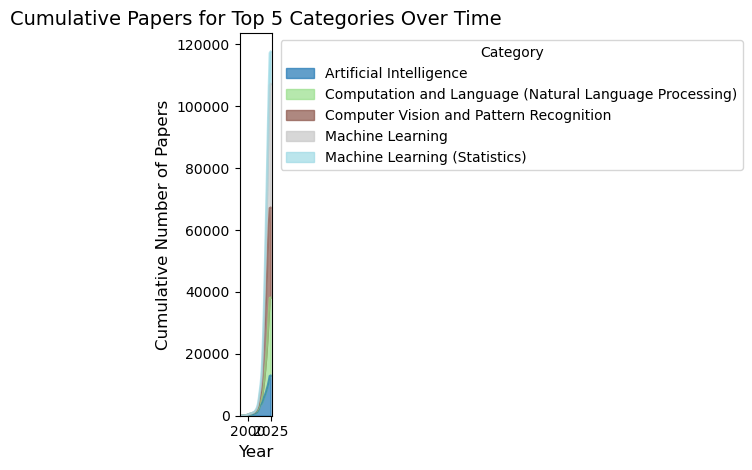

In [13]:
# 2. Area Plot: Cumulative Papers for Top 5 Categories Over Time
console.print("[bold blue]Plotting cumulative papers for top 5 categories[/bold blue]")
top_categories = df['category'].value_counts().head(5).index
df_top_cat = df[df['category'].isin(top_categories)]
cat_year_counts = df_top_cat.groupby(['year', 'category']).size().unstack(fill_value=0)
cumulative_counts = cat_year_counts.cumsum()
plt.figure(figsize=(18, 8))
cumulative_counts.plot(kind='area', stacked=True, colormap='tab20', alpha=0.7)
plt.title('Cumulative Papers for Top 5 Categories Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Cumulative Number of Papers', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('plots/cumulative_papers_top_categories_legend.png', dpi=300)
plt.show(); plt.close()
